**Part 2. AI Agent 활용 프로젝트**

- Chapter 03. N개 이상의 Agent

    - **📒[실습]** Clip 03. Network - 검색 결과를 차트로 그려주는 Agent🗒️

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")
_set_env("TAVILY_API_KEY")

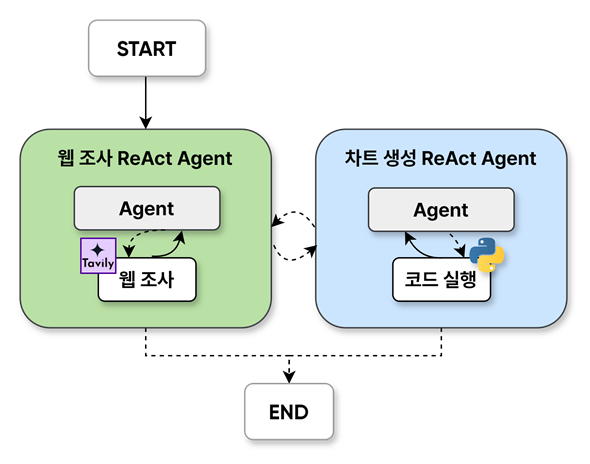

- 공용 시스템 프롬프트

In [2]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

### 검색을 기반으로 조사하는 Agent

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

In [4]:
from langchain_anthropic import ChatAnthropic
from langgraph.prebuilt import create_react_agent

llm = ChatAnthropic(model="claude-3-7-sonnet-20250219")

research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

In [5]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import MessagesState, END
from langgraph.types import Command


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        return END
    return goto


def research_node(state: MessagesState) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator") # END or "chart_generator"

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={"messages": result["messages"]},
        goto=goto,
    )


### 차트를 생성하는 Agent

In [6]:
from typing import Annotated
from langchain_core.tools import tool


@tool
def python_exec_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = exec(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [7]:
chart_agent = create_react_agent(
    llm,
    [python_exec_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

In [8]:
def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={"messages": result["messages"]},
        goto=goto,
    )

In [9]:
from langgraph.graph import StateGraph, START

graph_builder = StateGraph(MessagesState)
graph_builder.add_node("researcher", research_node)
graph_builder.add_node("chart_generator", chart_node)

graph_builder.add_edge(START, "researcher")
graph = graph_builder.compile()

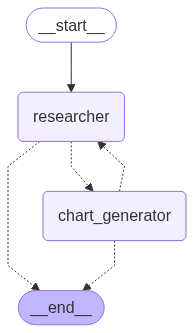

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

테스트 !

{'researcher': {'messages': [HumanMessage(content='2020년 한국의 코로나 19 확진자 수를 조사하여, 이를 차트로 만들어주세요. 누적확진자와 신규확진자가 모두 포함되어야 합니다.차트 속 글씨는 영어로 작성하세요.차트를 만들고 나면 끝내세요.', additional_kwargs={}, response_metadata={}, id='b6d46678-6762-4347-98ba-7c19b06b7f3f'), AIMessage(content=[{'text': "I'll help you research the COVID-19 cases in South Korea during 2020, including both cumulative and new cases. This information will be useful for creating a chart later.", 'type': 'text'}, {'id': 'toolu_011ChojRxNrPJ8mbYEp1hVSD', 'input': {'query': 'South Korea COVID-19 cases data 2020 cumulative and new daily cases statistics'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01Hpq2yJn44ReF6kx87L7tcv', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 631, 'output_tokens': 115}, 'model_name': 'claude-3-7-sonnet-20250219'}

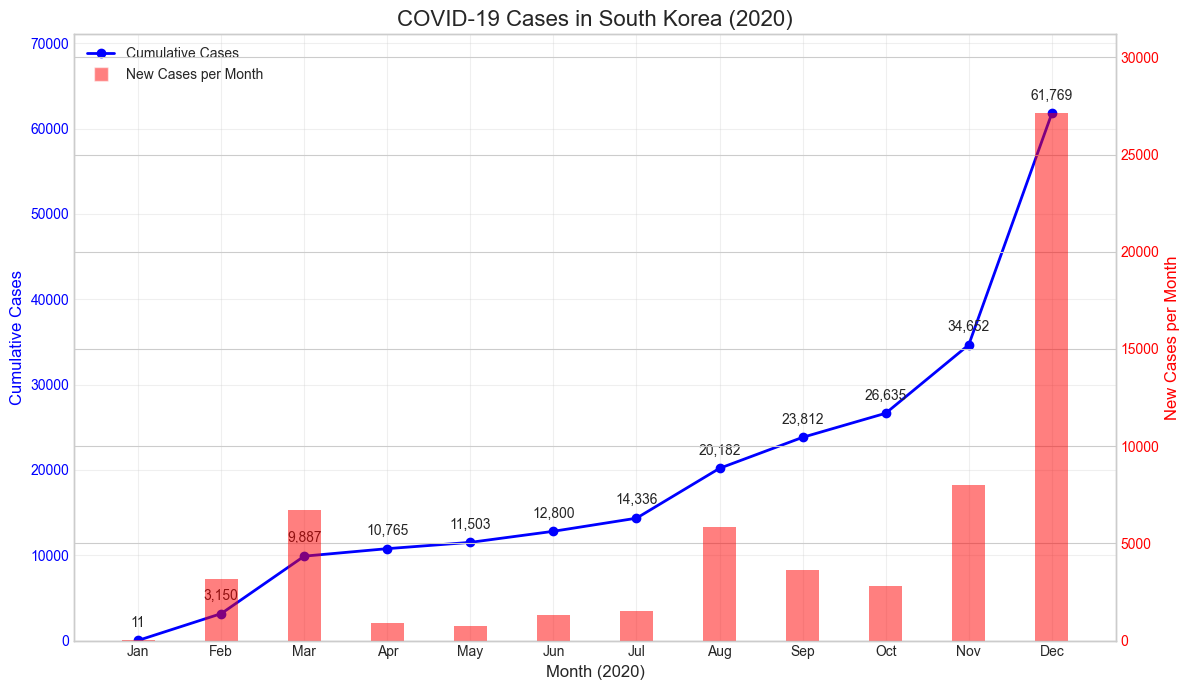

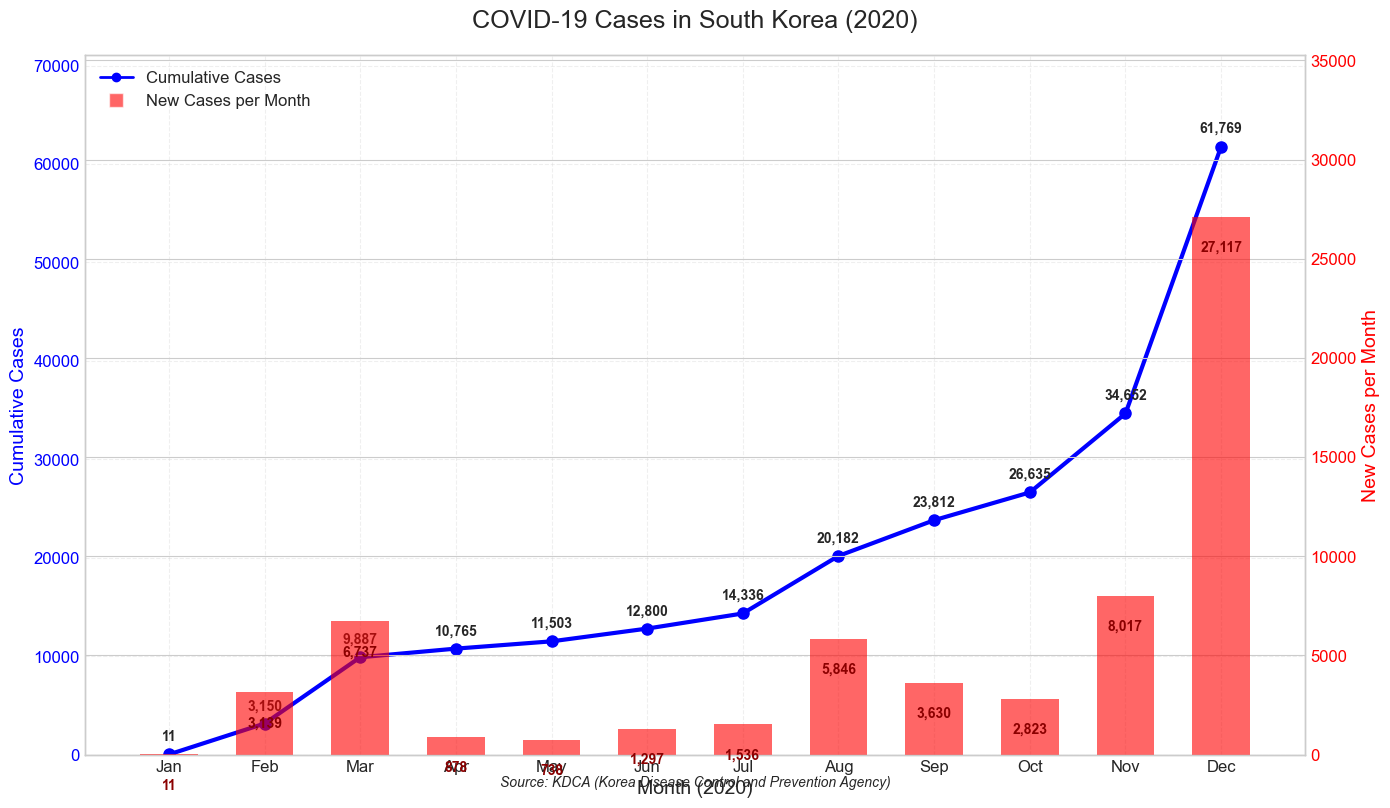

{'chart_generator': {'messages': [HumanMessage(content='2020년 한국의 코로나 19 확진자 수를 조사하여, 이를 차트로 만들어주세요. 누적확진자와 신규확진자가 모두 포함되어야 합니다.차트 속 글씨는 영어로 작성하세요.차트를 만들고 나면 끝내세요.', additional_kwargs={}, response_metadata={}, id='b6d46678-6762-4347-98ba-7c19b06b7f3f'), AIMessage(content=[{'text': "I'll help you research the COVID-19 cases in South Korea during 2020, including both cumulative and new cases. This information will be useful for creating a chart later.", 'type': 'text'}, {'id': 'toolu_011ChojRxNrPJ8mbYEp1hVSD', 'input': {'query': 'South Korea COVID-19 cases data 2020 cumulative and new daily cases statistics'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01Hpq2yJn44ReF6kx87L7tcv', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 631, 'output_tokens': 115}, 'model_name': 'claude-3-7-sonnet-20250

In [ ]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "2020년 한국의 코로나 19 확진자 수를 조사하여, 이를 차트로 만들어주세요. 누적확진자와 신규확진자가 모두 포함되어야 합니다."
                "차트 속 글씨는 영어로 작성하세요."
                "차트를 만들고 나면 끝내세요.",
            )
        ],
    },
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'researcher': {'messages': [HumanMessage(content='먼저, 지난 2020년 ~ 2024년의 한국의 GDP를 구한 다음, 이를 바탕으로 선형 차트를 만드세요. 차트 속 글씨는 영어로 작성하세요.차트를 만들고 나면 끝내세요.', additional_kwargs={}, response_metadata={}, id='096a668c-abf2-4b63-8452-ca73d55069a4'), AIMessage(content=[{'text': "I'll search for the GDP data of South Korea from 2020 to 2024. Let me gather this information.", 'type': 'text'}, {'id': 'toolu_01QPgufrv9bXQ94f8YVERH25', 'input': {'query': 'South Korea GDP data 2020 2021 2022 2023 2024 annual figures'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01UUTkP8tmKTs5fknqmY7ESa', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 617, 'output_tokens': 106}, 'model_name': 'claude-3-7-sonnet-20250219'}, id='run-7e83a0a6-2b81-410a-a36d-e5ba2cbe4565-0', tool_calls=[{'name': 'tavily_search_results_json', 'args

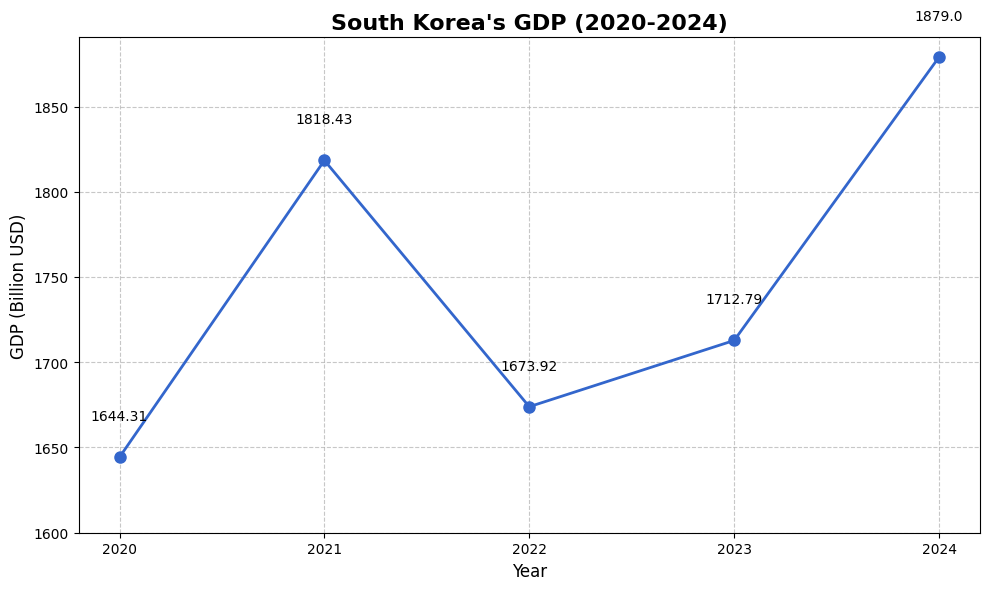

{'chart_generator': {'messages': [HumanMessage(content='먼저, 지난 2020년 ~ 2024년의 한국의 GDP를 구한 다음, 이를 바탕으로 선형 차트를 만드세요. 차트 속 글씨는 영어로 작성하세요.차트를 만들고 나면 끝내세요.', additional_kwargs={}, response_metadata={}, id='096a668c-abf2-4b63-8452-ca73d55069a4'), AIMessage(content=[{'text': "I'll search for the GDP data of South Korea from 2020 to 2024. Let me gather this information.", 'type': 'text'}, {'id': 'toolu_01QPgufrv9bXQ94f8YVERH25', 'input': {'query': 'South Korea GDP data 2020 2021 2022 2023 2024 annual figures'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01UUTkP8tmKTs5fknqmY7ESa', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 617, 'output_tokens': 106}, 'model_name': 'claude-3-7-sonnet-20250219'}, id='run-7e83a0a6-2b81-410a-a36d-e5ba2cbe4565-0', tool_calls=[{'name': 'tavily_search_results_json', 

In [ ]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "먼저, 지난 2020년 ~ 2024년의 한국의 GDP를 구한 다음, 이를 바탕으로 선형 차트를 만드세요. 차트 속 글씨는 영어로 작성하세요."
                "차트를 만들고 나면 끝내세요.",
            )
        ],
    },
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")